In [1]:
# Copyright (c) 2022 Graphcore Ltd. All rights reserved.

# Link Prediction Training for Knowledge Graphs using Distributed KGE on IPU (OGB-LSC)

This notebook covers training of a Knowledge Graph Embedding model using multiple IPUs and inference for Knowledge Graph Completion.

 - Model: [TransE](https://papers.nips.cc/paper/2013/hash/1cecc7a77928ca8133fa24680a88d2f9-Abstract.html)
 - Dataset: [ogbl-wikikg2](https://ogb.stanford.edu/docs/linkprop/#ogbl-wikikg2)
 - Execution scheme: Balanced Entity Sampling & Sharing ([BESS](https://arxiv.org/abs/2211.12281))

We demonstrate some of the techniques underlying Graphcore's winning entry to the link prediction track of the [2022 Open Graph Benchmark Large Scale Challenge](https://ogb.stanford.edu/neurips2022/). The dataset used here is similar to the large WikiKG90Mv2 dataset from the challenge, while being smaller, faster to train and linkable against the source Wikidata.

## 0. Preamble

Before getting started, we shuld note that this notebook relies on custom supporting code:
 - [kge_training.py](kge_training.py) - main KGE sampling, modeling, training code
   - [custom_ops.cpp](custom_ops.cpp) - a custom op and optimisation pattern to support IPU training
   - [Makefile](Makefile) - native build for `custom_ops.cpp`
 - [kge_mapping.py](kge_mapping.py) - utilities for interactive inference
   - [Preprocessing.ipynb](Preprocessing.ipynb) - for reference, what preprocessing steps have been taken
 - [requirements.txt](requirements.txt)

In particular, we would encourage reading & modifying [kge_training.py](kge_training.py).

---

**Note:** if you get the following error, please restart the notebook before re-running a fresh experiment.

```
RuntimeError: Model has already been wrapped in 'poptorch.trainingModel'. Call model.destroy() on the model to unwrap before wrapping again.
```

In [3]:
# Before we start, build C++ custom ops & import dependencies.

!pip install -qr requirements.txt
!make

%load_ext autoreload
%autoreload 2

import functools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
import tqdm
import torch as T

# Local modules - feel free to peek inside & modify
import kge_training
import kge_mapping

# Environment configuration
NUM_AVAILABLE_IPU = int(os.getenv("NUM_AVAILABLE_IPU", 16))
DATA_ROOT = Path(os.environ["DATASET_DIR"]) / "ogbl_wikikg2_custom"

if NUM_AVAILABLE_IPU >= 16:
    DEFAULT_EMBEDDING_SIZE = 200
    DEFAULT_OPTIMISER = "adamw"
else:
    DEFAULT_EMBEDDING_SIZE = 100
    DEFAULT_OPTIMISER = "sgdm"

print(f"Running on {NUM_AVAILABLE_IPU} IPUs")

make: 'build/custom_ops.so' is up to date.
Running on 4 IPUs


## 1. Data

To simplify the API for this example, we've pulled the data out of an OGB loader into a simple dataclass called `Dataset`.

In [4]:
# Load the dataset into memory & print some statistics.

data = kge_training.Dataset.load(DATA_ROOT / "ogbl_wikikg2.npz")

print(f"        Entities: {data.n_entity:>10,}")
print(f"  Relation types: {data.n_relation_type:>10}")
print(f"Training triples: {data.triples['train'].shape[0]:>10,}")
print()
print("Example train [head, relation, tail]:")
display(data.triples["train"][:4])

        Entities:  2,500,604
  Relation types:        535
Training triples: 16,109,182

Example train [head, relation, tail]:


array([[  70797,     274, 1730548],
       [ 675506,     436, 1556309],
       [1657671,      24, 1686053],
       [ 991166,      75, 2404597]])

## 2. Sharding

As the number of entities is large and our model will construct a trainable embedding for each entity, we will split entities evenly across IPUs. We use a simple balanced-random assignment of entities to shards, and use index arrays to map from entity to (shard, idx) and back to entity.

In [5]:
# Randomly shard entities & show a round-trip example.

sharding = kge_training.Sharding.create(n_entity=data.n_entity, n_shard=NUM_AVAILABLE_IPU, seed=None)

example_entity = 70797
example_entity_shard = sharding.entity_to_shard[example_entity]
example_entity_idx = sharding.entity_to_idx[example_entity]

print(f"Entity {example_entity}")
print(f"-> Shard {example_entity_shard}, Idx {example_entity_idx}")
print(f"-> Entity {sharding.shard_and_idx_to_entity[example_entity_shard, example_entity_idx]}")

Entity 70797
-> Shard 3, Idx 422334
-> Entity 70797


## 3. Batch sampling

The batch sampler is a key component of BESS. It is responsible for sampling balanced batches of triples and negative tail samples for the contrastive loss.

 - Group all triples in the dataset into buckets, according to the shard for their head & tail entities.
   - For example, with 4 shards, there will be 16 buckets, for each `(head shard, tail shard)` combination.
 - Sample `n_positive` triples from the dataset for each bucket.
   - This provides `head` and `relation` in the final batch.
 - Sample `n_negative` tail entities, uniformly at random for each bucket.
 - Concatenate the true tails with negative samples, and transpose them from `(head shard, tail shard, n_negative)` to `(tail shard, head shard, n_negative)` so that the index of the shard where the entity is stored comes first.
   - This provides `src_tails` in the final batch.
   
Each call to the batch sampler returns `n_batch_per_call` batches.

In [6]:
# Setup the batch sampler, and show an example batch.

batch_sampler = kge_training.BatchSampler(
    triples=data.triples["train"],
    sharding=sharding,
    n_positive=256 // sharding.n_shard,
    n_negative=256 // sharding.n_shard,
    n_batch_per_call=2000,
    seed=3000,
)
example_batch = next(batch_sampler)
print("Example batch:")
display({k: f"{v.dtype}{list(v.shape)}" for k, v in example_batch.items()})

Example batch:


{'head': 'int64[2000, 4, 4, 64]',
 'relation': 'int64[2000, 4, 4, 64]',
 'src_tails': 'int64[2000, 4, 4, 128]'}

## 3. Model

Create a `torch.nn.Module` with the model logic. The model is essentially:

```python
head_embeddings = entity_embedding[head, :]
relation_embeddings = relation_embedding[relation, :]
tail_embeddings = entity_embedding[tail, :]

score = -l1distance(head_embeddings + relation_embeddings, tail_embeddings)

loss = sampled_softmax_cross_entropy(score, tail_label, total_classes=n_entity)
```

where `tail` are the (positive and negative) tail candidates shared by the triples in the batch and `tail_label` are the ground-truth tails. In practice, `tail` is obtained from `src_tails` after sharing sharded embeddings between replicas according to the BESS scheme (see [kge_training.py](kge_training.py)). We also use separate implementations for CPU and IPU, since:

 - On CPU, sharded operations are written as batched PyTorch operations.
 - On IPU, sharded operations are written for a single shard, with explicit collectives (see `all_to_all`).

In [7]:
# Create and initialise the model, and show the output loss for an example batch (running on CPU).

model = kge_training.Model(
    embedding_size=DEFAULT_EMBEDDING_SIZE,
    sharding=sharding,
    n_relation_type=data.n_relation_type,
)
model.half()
print("   Parameters:", {k: f"{v.dtype}{list(v.shape)}" for k, v in model.named_parameters()})

example_loss = model(**{k: T.tensor(v[0]) for k, v in example_batch.items()})
print(" Example loss:", float(example_loss) / (sharding.n_shard ** 2 * batch_sampler.n_positive))
print("Baseline loss:", np.log(data.n_entity))

   Parameters: {'entity_embedding': 'torch.float16[4, 625151, 100]', 'relation_embedding': 'torch.float16[535, 100]'}
 Example loss: 14.732799530029297
Baseline loss: 14.732042860657849


## (3->5 Cheat code)

Training is fun, but it takes a while. If you want to skip to part 5, uncomment and execute the following cell first.

In [8]:
# # Load a pretrained checkpoint

# PRETRAINED_PATH = DATA_ROOT / f"parameters_s{model.sharding.n_shard}_e{model.embedding_size}.pt"
# try:
#     model.load(PRETRAINED_PATH)
#     sharding = model.sharding
#     del batch_sampler  # as `sharding` has been updated
# except FileNotFoundError as e:
#     print(f"Pre-trained checkpoint not found: {PRETRAINED_PATH}", file=sys.stderr)
#     print(f"Available: {', '.join(f.name for f in DATA_ROOT.iterdir() if f.suffix == '.pt')}", file=sys.stderr)

## 4. Training

Everything is ready to start training. _We recommend you **start running** the next cell while you read._

Most of the training logic isn't specific to KGE models, so please see PopTorch [documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/intro.html) for general IPU training guidance.

An important detail is the use of `replicaGrouping` on the `entity_embedding` parameter:

```python
ipu_model.entity_embedding.replicaGrouping(
    poptorch.CommGroupType.NoGrouping,
    0,
    poptorch.VariableRetrievalMode.OnePerGroup,
)
```

This means that the leading axis of `entity_embedding`, shape `(n_shard, max_entity_per_shard, embedding_size)`, is used to split `entity_embedding` across replicas (in this case, across 4 IPUs). This is critical for memory use, as each IPU will now store only `1/n_shard` of the global embedding table. The model then executes on each IPU as if `entity_embedding` is of shape `(max_entity_per_shard, embedding_size)`, but has access to state held on other IPUs via cross-replica collectives such as `all_to_all()`.

**Training parameters (4-IPU variant)**

| Parameter | Default value | Explanation |
| --- | --- | --- |
| `n_shard` | $4$ | We can fit 2.5M entities on 4 IPUs with baseline settings. More IPUs would allow Adam, larger embedding size, etc. |
| `optimiser` | "sgdm" (SGD with momentum) | This reduces optimiser state memory usage versus Adam, although it has a slight negative impact on MRR. |
| `lr` | $10^{-3}$ | Chosen via sweep. |
| `sgdm_momentum` | $0.95$ | Chosen via sweep. |
| `weight_decay` | $0$ | Useful for regularisation. Not required with default settings. |
| `embedding_size` | $100$ | Good performance, within memory limitations. |

**While it's training, why not...**
 - Read through some key implementation highlights in [kge_training.py](kge_training.py)
   - `Model.forward_ipu`, the core model
   - `BatchSampler.__next__`, BESS batch sampler (if you're brave - we recommend reading the theoretical explanation in the technical report first)
   - `create_train_step`, training configuration, unifying the IPU and CPU training interface
 - Learn more about the models & BESS from our [technical report](https://arxiv.org/abs/2211.12281)

In [9]:
# Run training. Note that there are longer pauses for validation.
# Most of the inline code is for progress tracking

n_step = int(8e6 / model.sharding.n_shard)
steps = kge_training.train(
    model, batch_sampler,
    n_step=n_step,
    optimiser=DEFAULT_OPTIMISER,
    lr=1e-3,
    sgdm_momentum=0.95,
    weight_decay=0,
    valid_triples=data.sample("valid", n=int(2e3), seed=4000),
    valid_interval=n_step // 5,
    device="ipu",
)
full_log = [next(steps)]  # trigger compilation
steps = tqdm.tqdm(steps, desc="training", total=n_step // batch_sampler.n_batch_per_call, ncols=140)
for step in steps:
    full_log.append(step)
    steps.set_postfix_str(", ".join(f"{k}: {v:.3g}" for k, v in step.items()))
    if "mrr" in step:
        steps.clear()
        print(step, flush=True)
model.save(Path("parameters.pt"))

[22:50:04.501] [poptorch:cpp] [warning] [DISPATCHER] Tensor (ptr 0xa459b00) type coerced from Long to Int
Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00]
2022-12-19T22:52:22.931490Z popart:session 3775550.3775550 W: Rng state buffer was not serialized.You did not load poplar Engine.Remember that if you would like to run the model using the model runtime then you have to create your own buffer and callback in your model runtime application for rngStateTensor.


{'step': 400000, 'example': 409600000, 'mrr': 0.23015555555555556, 'loss': 4.519117832183838, 'elapsed': 42.035274028778076}


{'step': 800000, 'example': 819200000, 'mrr': 0.2608888888888889, 'loss': 3.64971923828125, 'elapsed': 43.9774055480957}


{'step': 1200000, 'example': 1228800000, 'mrr': 0.28966984126984124, 'loss': 3.731241464614868, 'elapsed': 45.619216203689575}


{'step': 1600000, 'example': 1638400000, 'mrr': 0.2843458333333333, 'loss': 3.528998851776123, 'elapsed': 41.735044717788696}


{'step': 2000000, 'example': 2048000000, 'mrr': 0.2755638888888889, 'elapsed': 44.26258563995361}


training: 100%|██████████████████████████████| 1000/1000 [25:38<00:00,  1.54s/it, step: 2e+06, example: 2.05e+09, mrr: 0.276, elapsed: 44.3]
/a/work/douglaso_research/PoplarKGE/demo/.wenvs/3.1.0-EA.1+1187/lib/python3.8/site-packages/torch/nn/modules/module.py:1428: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


### How did training go?

> Regarding validation MRR, note that the official ogbl-wikikg2 task provides a hit-list of 500 tail candidates for each query, which makes the MRR objective considerably easier, since the model has 500 options to choose from instead of 2.5 million. We do not use the hit-list and score each query against all entities in the KG, to exemplify a more general link-prediction pipeline. The full ogbl-wikikg2 task also involves both `(head, relation, ?)` and `(?, relation, tail)` queries, while our example uses only the former.

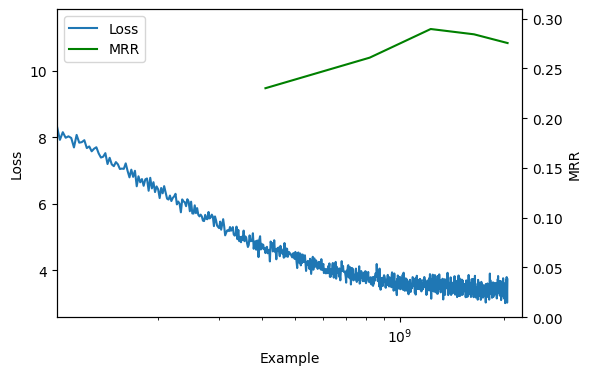

In [10]:
# Plot training curves. Please try to zone out the inline plotting code.

df = pd.DataFrame(full_log)
plt.figure(figsize=(6, 4))
ax0, ax1 = plt.gca(), plt.twinx()
line0, = ax0.plot(df.example, df.loss)
d = df[~df.mrr.isna()]
line1, = ax1.plot(d.example, d.mrr, color='g')
ax0.set_xscale("log")
ax0.set_xlim((df.example.max()/20, df.example.max() * 1.1))
ax0.set_xlabel("Example")
ax0.set_ylabel("Loss")
ax1.set_ylim((0, df.mrr.max() + 0.02))
ax1.set_ylabel("MRR")
plt.legend([line0, line1], ["Loss", "MRR"]);

## 5. Inference

While the MRR numbers we've seen during training seem reasonable for this kind of model, we would like to get a more direct impression of model performance.

The ogbl-wikikg2 dataset helpfully includes instructions for mapping entity and relation IDs back to Wikidata items and linking properties, which are interpretable. As the naive way of doing this would be prohibitively slow, we have built a mapping database from Wikidata dumps. This allows us to map text queries to and from entity and relation type IDs.

_Please play with the query strings in the interface below to explore the model._

**Note:**
 - Items under "head" and "relation" are text search matches, while those under "tail predictions" are the most likely (ordered) predictions from the KGE model.
 - Predictor query strings can use [SQLite FTS3 syntax](https://www.sqlite.org/fts3.html).
 - Any tail predictions for which the triple `(head, relation, tail)` is present in the training dataset are shown with a green border.
 - Some labels are missing. These seem to be redirection IDs, which were presumably modified since the 2015 dump in the dataset.
 - We run inference on the CPU for the sake of simplicity, however BESS effectively supports distribution also at inference time (see the [technical report](https://arxiv.org/abs/2211.12281) for implementation details).

In [11]:
# Use our mapping database to perform link prediction.

predictor = kge_mapping.Predictor(
    kge_mapping.Database(DATA_ROOT / "ogbl_wikikg2_mapping.sqlite"),
    functools.partial(kge_training.predict, model=model, n_best=10),
    train_hrt=data.triples["train"],
    n_entity=data.n_entity,
    n_relation_type=data.n_relation_type,
    n_suggestions=10,
)
print("Top 100 Relations:", '  '.join([repr(r.wikidata_label) for r in predictor.database.all_relations][:100]))

Top 100 Relations: 'instance of'  'occupation'  'sex or gender'  'given name'  'country of citizenship'  'place of birth'  'cast member'  'country'  'located in the administrative territorial entity'  'member of sports team'  'place of death'  'award received'  'educated at'  'position held'  'shares border with'  'genre'  'follows'  'followed by'  'member of political party'  'contains the administrative territorial entity'  'participant in'  'taxon rank'  'parent taxon'  'family name'  'performer'  'record label'  'original language of film or TV show'  'director'  'employer'  'location'  'heritage designation'  'country of origin'  ''  'part of'  'child'  'member of'  'sport'  'languages spoken, written or signed'  'depicts'  'discoverer or inventor'  'made from material'  'screenwriter'  'subclass of'  'conflict'  'father'  'work location'  'minor planet group'  'producer'  'located on street'  'twinned administrative body'  'site of astronomical discovery'  'located in time zone' 

In [12]:
predictor("Ray Charles", "genre")

Predictions(heads=[Entry(type='entity', idx=1848896, wikidata_id='Q544387', wikidata_label='Ray Charles'), Entry(type='entity', idx=1205985, wikidata_id='Q2960091', wikidata_label='Charles Ray'), Entry(type='entity', idx=1747151, wikidata_id='Q5075549', wikidata_label='Charles Bennett Ray'), Entry(type='entity', idx=1140750, wikidata_id='Q2684150', wikidata_label='Michael Ray Charles'), Entry(type='entity', idx=1352285, wikidata_id='Q3420493', wikidata_label='Ray Charles and Betty Carter'), Entry(type='entity', idx=1502145, wikidata_id='Q3930614', wikidata_label='Ray Charles'), Entry(type='entity', idx=1750372, wikidata_id='Q5081956', wikidata_label='Charles Ray Hatcher'), Entry(type='entity', idx=2221334, wikidata_id='Q7297319', wikidata_label='Ray Charles'), Entry(type='entity', idx=2418556, wikidata_id='Q872846', wikidata_label='Charles Ray'), Entry(type='entity', idx=852180, wikidata_id='Q18658533', wikidata_label='Charles Ray Jordan')], relations=[Entry(type='relation', idx=90, wikidata_id='P136', wikidata_label='genre')], tail_predictions=[Prediction(type='entity', idx=281125, wikidata_id='Q131272', wikidata_label='soul music', in_training=False), Prediction(type='entity', idx=1432319, wikidata_id='Q37073', wikidata_label='pop music', in_training=False), Prediction(type='entity', idx=2400769, wikidata_id='Q8341', wikidata_label='jazz', in_training=True), Prediction(type='entity', idx=2400984, wikidata_id='Q83440', wikidata_label='country music', in_training=False), Prediction(type='entity', idx=135378, wikidata_id='Q11399', wikidata_label='rock music', in_training=False), Prediction(type='entity', idx=851623, wikidata_id='Q186472', wikidata_label='folk rock', in_training=False), Prediction(type='entity', idx=86201, wikidata_id='Q1092837', wikidata_label='post-bop', in_training=False), Prediction(type='entity', idx=1008494, wikidata_id='Q217467', wikidata_label='art rock', in_training=False), Prediction(type='entity', idx=1629417, wikidata_id='Q45981', wikidata_label='rhythm and blues', in_training=False), Prediction(type='entity', idx=2405042, wikidata_id='Q842256', wikidata_label='musical film', in_training=False)])

## 6. Wrapping up

In this notebook, we've seen BESS applied to distributed KGE training on the IPU. In particular, we emphasise:
 - The batch sampler is an important component in BESS.
 - Sharding parameters across IPUs using `replicaGrouping` is an effective way to reduce memory usage.
 - It is interesting to explore KGE model predictions qualitatively as well as quantitatively.

If you're interested to explore further, we suggest:
 - Implement and test another scoring function, for example [RotatE](https://arxiv.org/abs/1902.10197) or [ComplEx](https://arxiv.org/abs/1606.06357).
 - How does the number of negative samples affect performance?
 - (Requires more than 4 IPUs): try increasing `embedding_size`.
 - (Requires more than 4 IPUs): try training with Adam.
